# Prophesee Data Science - Predicting number of shares for an Article

<b>Problem Statement</b>: Blogs and articles are the key tools for any publisher brand, but not every article is a hit. Brands are now using digital analytics to increase their reach and target the right audience. One such popular brand of Europe wants to improve their content, so that it reaches more number of people. The brand wants to predict number of shares one article can garner based on certain features.

In [12]:
# imports
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from patsy import dmatrices
from sklearn.metrics import roc_auc_score
import xgboost as xgb
#from xgboost.sklearn import XGBClassifier

# this allows plots to appear directly in the notebook
%matplotlib inline

<H3>Articles Data</h3><br>
Let's take a look at some data, ask some questions about that data, and then use machine learning models to answer those questions!

In [13]:
# read data into a DataFrame
df = pd.read_csv("data/ArticlesData.csv")
df.head()

,id,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,num_keywords,...,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,global_subjectivity,global_sentiment_polarity,shares
0,1,12,219,0.663594,1,0.815385,4,1,0,5,...,0,0,0,0,0,0,0,0.521617,0.092562,593
1,2,9,255,0.604743,1,0.791946,3,1,0,4,...,0,0,0,0,0,0,0,0.341246,0.148948,711
2,3,9,211,0.575130,1,0.663866,3,1,0,6,...,0,0,0,0,0,0,0,0.702222,0.323333,1500
3,4,9,531,0.503788,1,0.665635,9,1,0,7,...,0,0,0,0,0,0,0,0.429850,0.100705,1200
4,5,13,1072,0.415646,1,0.540890,19,20,0,7,...,0,0,0,0,0,0,0,0.513502,0.281003,505


what are the **features**?<br>
<ul><li>id:                             Unique Id</li> 
    <li>n_tokens_title:                Number of words in the title</li>
    <li>n_tokens_content:              Number of words in the content</li>
    <li>n_unique_tokens:               Rate of unique words in the content</li>
    <li>n_non_stop_words:              Rate of non-stop words in the content</li>
    <li>n_non_stop_unique_tokens:      Rate of unique non-stop words in the content</li>
    <li>num_hrefs:                     Number of links</li>
    <li>num_imgs:                      Number of images</li>
    <li>num_videos:                    Number of videos</li>
    <li>num_keywords:                  Number of keywords in the metadata</li>
    <li>data_channel_is_lifestyle:     Is data channel 'Lifestyle'?</li>
    <li>data_channel_is_entertainment: Is data channel 'Entertainment'?</li>
    <li>data_channel_is_bus:           Is data channel 'Business'?</li>
    <li>data_channel_is_socmed:        Is data channel 'Social Media'?</li>
    <li>data_channel_is_tech:          Is data channel 'Tech'?</li>
    <li>data_channel_is_world:         Is data channel 'World'?</li>
    <li>weekday_is_monday:             Was the article published on a Monday?</li>
    <li>weekday_is_tuesday:            Was the article published on a Tuesday?</li>
    <li>weekday_is_wednesday:          Was the article published on a Wednesday?</li>
    <li>weekday_is_thursday:           Was the article published on a Thursday?</li>
    <li>weekday_is_friday:             Was the article published on a Friday?</li>
    <li>weekday_is_saturday:           Was the article published on a Saturday?</li>
    <li>weekday_is_sunday:             Was the article published on a Sunday?</li>
    <li>is_weekend:                    Was the article published on the weekend?</li>
    <li>global_subjectivity:           Text subjectivity</li>
    <li>global_sentiment_polarity:     Text sentiment polarity</li></ul><br>
    what is the **response**?<br>
<ul><li>shares:                             Number of shares</li> 

In [14]:
# removing unwanted white spaces from features name
df.columns = [x.strip() for x in list(df)]
# print the shape of the DataFrame
df.shape

(39644, 27)

There are 39644 **observations**. Thus 39644 Articles in the dataset

<h2>Data Exploration</h2>

In [15]:
# let's see distribution of target variable 'shares'
df['shares'].describe()
df['shares'].quantile([.10,.25,.5,.75,.9,.95,.99])

0.10      708
0.25      946
0.50     1400
0.75     2800
0.90     6200
0.95    10800
0.99    31657
Name: shares, dtype: float64

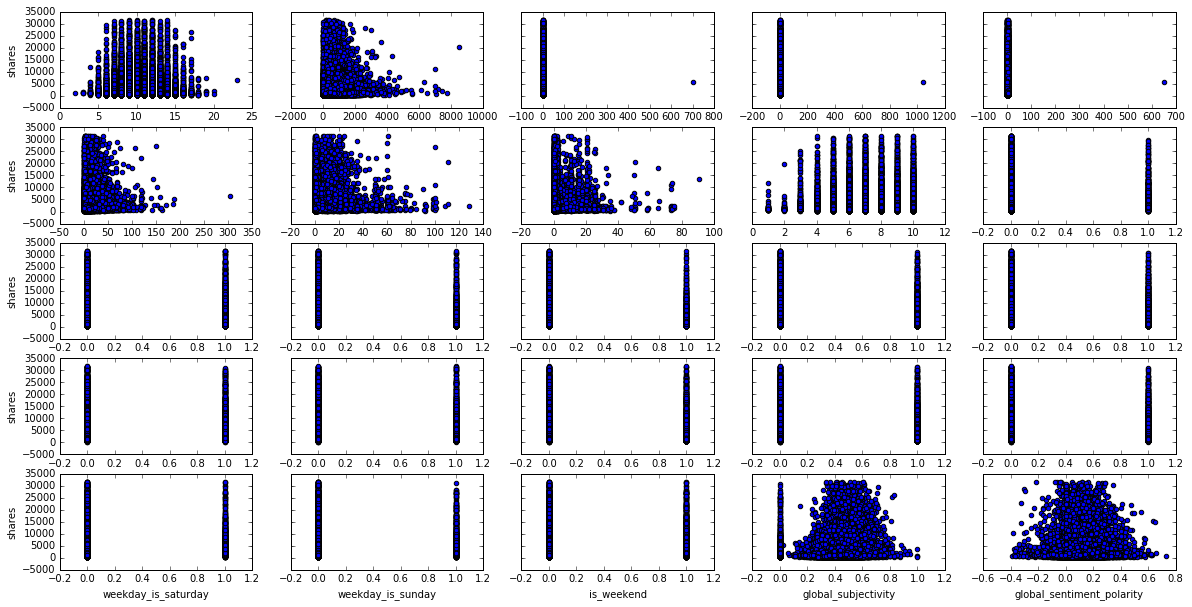

In [16]:
# remove outliers by removing top 1% and bottom 1% quantile data
df = df[(df['shares']>df['shares'].quantile(.01))&(df['shares']<df['shares'].quantile(.99))]

# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(5, 5, sharey=True)
features = list(df)[1:-1]
target = list(df)[-1]
row = 0
column = 0
for i in range(0,len(features)):
    column = i%5
    df.plot(kind='scatter', x=features[i], y=target, ax=axs[row,column], figsize=(20, 10))
    row = row+1 if column==4 else row

In [17]:
# also find pearson correlation between features and target
df.corr(method='pearson',min_periods=1)['shares']

id                              -0.027401
n_tokens_title                  -0.014021
n_tokens_content                 0.004610
n_unique_tokens                  0.003378
n_non_stop_words                 0.003147
n_non_stop_unique_tokens         0.002217
num_hrefs                        0.075471
num_imgs                         0.073834
num_videos                       0.037906
num_keywords                     0.041547
data_channel_is_lifestyle        0.025247
data_channel_is_entertainment   -0.038246
data_channel_is_bus             -0.044741
data_channel_is_socmed           0.042730
data_channel_is_tech             0.011349
data_channel_is_world           -0.100002
weekday_is_monday                0.001649
weekday_is_tuesday              -0.017005
weekday_is_wednesday            -0.021200
weekday_is_thursday             -0.016228
weekday_is_friday               -0.004159
weekday_is_saturday              0.043211
weekday_is_sunday                0.045661
is_weekend                       0

Seeing above correlation we can conclude some insights like:
<li>Articles published on weekends (Saturday,Sunday) and monday performs better than other weekdays.</li><li>Increase in length of title corresponds to decrease in number of shares</li><li>Datachannel social-media and tech perform better than others</li>
<br>
But as the correlation is not that much strong so applying linear regression does not yield any good prediction model here<br>
Lets try solving by making continuous target variable into classes of buckets and then using various classification models to predict the number of shares an article can get. 

<h3>Deciding buckets for target variable</h3><br>
Looking at quantiles of dataset lets make classes for 25%,50%,75% quantiles
<li><b>class 1 :</b> < 1000</li>
<li><b>class 2 :</b> >= 1000 and < 2000</li>
<li><b>class 3 :</b> >= 2000</li>



In [18]:
# creating class target variable in dataframe
targetClass = []
for value in list(df['shares']):
    if value<1000:
        targetClass.append(1)
    elif value>=1000 and value<2000:
        targetClass.append(2)
    elif value>=2000:
        targetClass.append(3)
df['targetClass'] = targetClass
df['targetClass'].value_counts()

2    14007
3    13993
1    10849
Name: targetClass, dtype: int64

In [19]:
#new dataframe
df.head()

,id,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,num_keywords,...,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,global_subjectivity,global_sentiment_polarity,shares,targetClass
0,1,12,219,0.663594,1,0.815385,4,1,0,5,...,0,0,0,0,0,0,0.521617,0.092562,593,1
1,2,9,255,0.604743,1,0.791946,3,1,0,4,...,0,0,0,0,0,0,0.341246,0.148948,711,1
2,3,9,211,0.575130,1,0.663866,3,1,0,6,...,0,0,0,0,0,0,0.702222,0.323333,1500,2
3,4,9,531,0.503788,1,0.665635,9,1,0,7,...,0,0,0,0,0,0,0.429850,0.100705,1200,2
4,5,13,1072,0.415646,1,0.540890,19,20,0,7,...,0,0,0,0,0,0,0.513502,0.281003,505,1


Also lets transform some binary feature vectors under one categorical fetaure set i.e for publication mode and publication weekday.

In [20]:
# Publication weekday
df1 = df[["weekday_is_monday","weekday_is_tuesday","weekday_is_wednesday","weekday_is_thursday","weekday_is_friday","weekday_is_saturday","weekday_is_sunday"]]
weekdays = ["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]
days = []

for index,row in df1.iterrows():
    try:
        dy = weekdays[dict(row).values().index(1)]
    except:
        dy = None
    days.append(dy)
df['weekday'] = days

# Publication mode
df2 = df[["data_channel_is_lifestyle","data_channel_is_entertainment","data_channel_is_bus","data_channel_is_socmed","data_channel_is_tech","data_channel_is_world"]]
datachannels = ["lifestyle","entertainment","business","socialmedia","technology","world"]
channels = []

for index,row in df2.iterrows():
    try:
        chn = datachannels[dict(row).values().index(1)]
    except ValueError:
        chn = None
    channels.append(chn)
df['datachannel'] = channels

In [21]:
df.groupby('targetClass').mean()

,id,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,num_keywords,...,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,global_subjectivity,global_sentiment_polarity,shares
targetClass,,,,,,,,,,,,,,,,,,,,,
1,20339.978708,10.558116,515.909393,0.540235,0.973362,0.684307,9.534151,3.898332,1.249424,7.061941,...,0.210158,0.219467,0.205180,0.133469,0.020371,0.029127,0.049498,0.432588,0.109542,767.702830
2,20233.944099,10.399158,545.260084,0.530652,0.973299,0.674089,10.613479,4.303206,1.178197,7.184693,...,0.183908,0.178839,0.177840,0.149283,0.067252,0.077390,0.144642,0.442013,0.120168,1377.397016
3,19089.602801,10.283499,572.673051,0.571904,1.038877,0.707980,12.132280,5.277710,1.322518,7.385621,...,0.170728,0.171228,0.171943,0.145859,0.088544,0.092904,0.181448,0.452079,0.126227,5544.515115


Increase in number of links,images,videos on article corresponds to increase in shares

In [22]:
df.groupby('is_weekend').mean()

,id,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,num_keywords,...,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,global_subjectivity,global_sentiment_polarity,shares,targetClass
is_weekend,,,,,,,,,,,,,,,,,,,,,
0,19859.983258,10.407681,537.214567,0.55258,1.001215,0.693605,10.533973,4.368329,1.274306,7.165081,...,0.214686,0.215782,0.211071,0.165348,0.000000,0.000000,0.442061,0.118547,2615.388212,2.033840
1,19794.441592,10.363583,611.249118,0.51913,0.968640,0.659682,13.009800,5.684241,1.089769,7.604469,...,0.000000,0.000000,0.000000,0.000000,0.470796,0.529204,0.449260,0.124915,3321.227362,2.392395


Weekend post corresponds to higher number of shares campared to other weekdays.

<h2>Data Visualization</h2><br>
Let's start with histograms of title and content length.

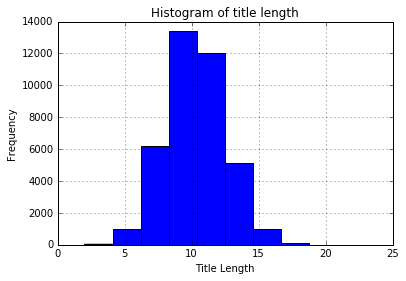

In [23]:
# histogram of title length
df.n_tokens_title.hist()
plt.title('Histogram of title length')
plt.xlabel('Title Length')
plt.ylabel('Frequency')

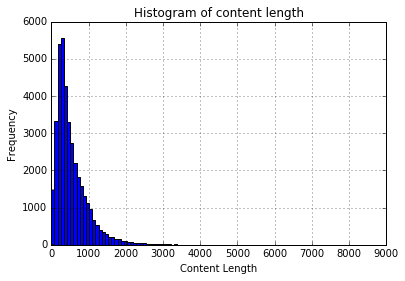

In [24]:
# histogram of content length
df.n_tokens_content.hist(bins=100)
plt.title('Histogram of content length')
plt.xlabel('Content Length')
plt.ylabel('Frequency')

As seen content length seems highly skewed, lets apply log to convert it into normal form.

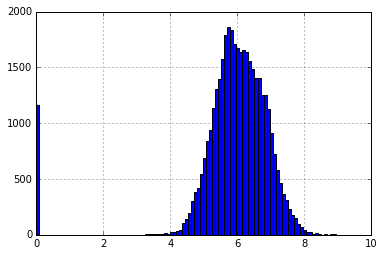

In [25]:
# applying log on content length
df['n_tokens_content'] = np.log1p(df.n_tokens_content)
df.n_tokens_content.hist(bins=100)

Lets take a look at how each datachannel is performing by taking a look at avg number of shares.

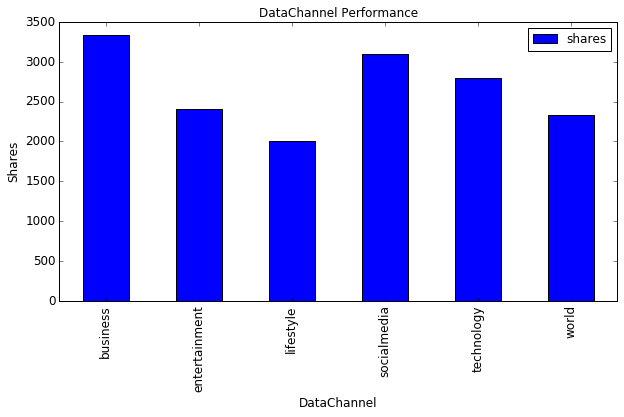

In [26]:
datachannel = df.groupby(["datachannel"]).aggregate({'shares':np.mean})
ax = datachannel.plot(kind='bar', title ="DataChannel Performance",figsize=(10,5),legend=True, fontsize=12)
ax.set_xlabel("DataChannel",fontsize=12)
ax.set_ylabel("Shares",fontsize=12)
plt.show()

Business and social media out performs other datachannel.

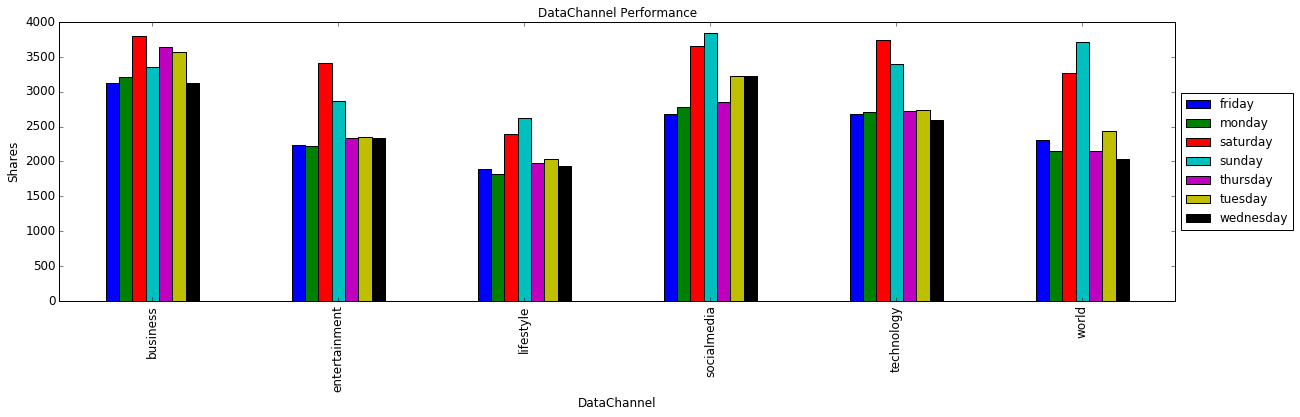

In [27]:
channel_week = df.groupby(["datachannel","weekday"]).aggregate({'shares':np.mean})
channel_week = channel_week.reset_index()
channel_week = channel_week.pivot(index='datachannel', columns='weekday', values='shares')
ax = channel_week.plot(kind='bar', title ="DataChannel Performance",figsize=(20,5),legend=True, fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("DataChannel",fontsize=12)
ax.set_ylabel("Shares",fontsize=12)
plt.show()

For each datachannel weekends performs the better. Saturday is best choice for business,entertainment, while sunday is best day for social media,lifestyle and world. 

<h2>Prepare Data for Random Forest</h2><br>
To prepare the data, we are deciding the feature set and target variable using dmatrices function from the patsy module.

In [30]:
# feature set and target set from dataframe
y, X = dmatrices('targetClass ~ n_tokens_title + n_tokens_content+n_unique_tokens+n_non_stop_unique_tokens+num_imgs+ num_hrefs+num_videos+num_keywords+weekday+is_weekend+datachannel+global_subjectivity+global_sentiment_polarity',
                  df, return_type="dataframe")
X = X.as_matrix()
y = y['targetClass'] 

<h2>Random Forest</h2><br>
Let's go ahead and run Random Forest on the entire data set, and see how accurate it is!

In [31]:
# Create Random Forest object
model= RandomForestClassifier(n_estimators=300,min_samples_leaf=5,oob_score =True,max_features='sqrt')
# Train the model using the training sets and check score
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [32]:
model.score(X, y)

0.88061605759591721

88% accuracy seems good, but what's the null error rate?

<h2>Model Evaluation Using a Validation Set</h2><br>
So far, we have trained and tested on the same set. Let's instead split the data into a training set and a testing set.

In [71]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = RandomForestClassifier(n_estimators=300,min_samples_leaf=5,oob_score =True,max_features='sqrt')
model2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

We now need to predict class labels for the test set. We will also generate the class probabilities, just to take a look.

In [72]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print predicted

[ 1.  1.  1. ...,  3.  1.  2.]


In [73]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print probs

[[ 0.46635369  0.28001489  0.25363142]
 [ 0.40664069  0.34675887  0.24660044]
 [ 0.4801997   0.39529175  0.12450855]
 ..., 
 [ 0.18220916  0.34978385  0.46800698]
 [ 0.62099913  0.24276358  0.13623728]
 [ 0.22838982  0.39800972  0.37360046]]


Now let's generate some evaluation metrics.

In [74]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)

0.456257594168


The accuracy comes out to be 46%.

We can also see the confusion matrix and a classification report with other metrics to improve our model.

In [70]:
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

[[1315 1001  539]
 [ 952 1410 1283]
 [ 591 1040 1745]]
             precision    recall  f1-score   support

        1.0       0.46      0.46      0.46      2855
        2.0       0.41      0.39      0.40      3645
        3.0       0.49      0.52      0.50      3376

avg / total       0.45      0.45      0.45      9876



<h2>Model Evaluation Using Cross-Validation</h2><br>
Now let's try 10-fold cross-validation, to see if the accuracy holds up more rigorously.

In [ ]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(model2, X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

Looks good. It's still performing at 46% accuracy.

<h2>Next Steps</h2><br>
There are many different steps that could be tried in order to improve the model:<br>
<li>Removing features and deriving new features</li><li>regularization techniques</li><li>Applying boosting Algorithms</li> 